# Tracer budgets MOM6 NCAR configuration
The following variables are required at double precision output for closing the **heat** budget:

'opottemptend', 'T_advection_xy', 'Th_tendency_vert_remap', 'boundary_forcing_heat_tendency', 'opottempdiff', 'opottemppmdiff',
                 'frazil_heat_tendency', 'KPP_NLT_temp_budget', 'T_lbdxy_cont_tendency'
                 
The following variables are required at double precision to close the **salt** budget: 

'S_advection_xy', 'Sh_tendency_vert_remap', 'boundary_forcing_salt_tendency', osaltpmdiff', 'osaltdiff', 
'KPP_NLT_saln_budget'*1e-3 (because there is a bug in the conversion factor), 'S_lbdxy_cont_tendency'
                 
A short run with all this output at double precision is available here: /glade/scratch/deppenme/archive/gmom.e23.GJRAv3.TL319_t061_zstar_N65.testbudget2.001/ocn/hist/
                 
Description of what they are can be found in the labels of the plot below. 


--------------

TO DO: 
- test different vertical coordinate
- test different temporal resolutions

### Load modules, start cluster

In [1]:
# Load required modules
import warnings
warnings.filterwarnings("ignore") # I don't want any warnings (: 

# the usual suspects
import numpy as np
from datetime import date
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import glob
import nc_time_axis # it says I need this to plot.. not sure 

# dask helpers 
from distributed import Client
from ncar_jobqueue import NCARCluster

# get mom6-tools 
import mom6_tools

In [2]:
cluster = NCARCluster(cores=4,
    processes=1,
    resource_spec='select=1:ncpus=1:mem=10GB',
)
cluster.scale(40)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.33:44824,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/deppenme/proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
# get the data
dirname = "/glade/scratch/deppenme/archive/gmom.e23.GJRAv3.TL319_t061_zstar_N65.testbudget2.001/ocn/hist"
static = xr.open_dataset(*glob.glob(f"{dirname}/*static*.nc"))
ds_hb = xr.open_mfdataset(
    sorted(glob.glob(f"{dirname}/gmom.e23.GJRAv3.TL319_t061_zstar_N65.testbudget2.001.mom6.hm_0001_01_??.nc")),
    coords="minimal",
    data_vars="minimal",
    compat="override",
    use_cftime=True,
    parallel=True,
)
ds_hb.coords.update(static.drop("time"))

## Heat budget 

In [4]:
# try for one location first 
ds_0N140W = ds_hb.sel(xh=-140, yh=0, method='nearest')

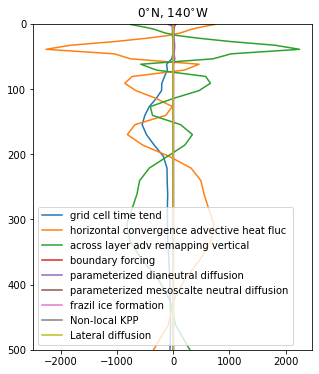

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5,6))

ax.plot(ds_0N140W.opottemptend.isel(time=5), ds_0N140W.zl, label='grid cell time tend')
ax.plot(ds_0N140W.T_advection_xy.isel(time=5), ds_0N140W.zl, label='horizontal convergence advective heat flux')
ax.plot(ds_0N140W.Th_tendency_vert_remap.isel(time=5), ds_0N140W.zl, label='across layer adv remapping vertical')
ax.plot(ds_0N140W.boundary_forcing_heat_tendency.isel(time=5), ds_0N140W.zl, label='boundary forcing')
ax.plot(ds_0N140W.opottempdiff.isel(time=5), ds_0N140W.zl, label='parameterized dianeutral diffusion')
ax.plot(ds_0N140W.opottemppmdiff.isel(time=5), ds_0N140W.zl, label='parameterized mesoscalte neutral diffusion')
ax.plot(ds_0N140W.frazil_heat_tendency.isel(time=5), ds_0N140W.zl, label='frazil ice formation')
ax.plot(ds_0N140W.KPP_NLT_temp_budget.isel(time=5), ds_0N140W.zl, label='Non-local KPP')
ax.plot(ds_0N140W.T_lbdxy_cont_tendency.isel(time=5), ds_0N140W.zl, label='Lateral diffusion')

ax.set_ylim(500,0)
ax.legend(loc='lower left')
ax.set_title(r'0$^{\circ}$N, 140$^{\circ}$W')
plt.savefig('hb_0N140W_mom_zstar.png', bbox_inches='tight')

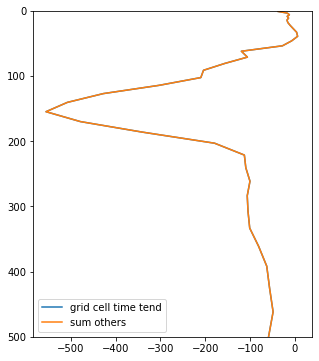

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5,6))

ax.plot(ds_0N140W.opottemptend.isel(time=5), ds_0N140W.zl, label='grid cell time tend')
ax.plot((ds_0N140W.T_advection_xy
        + 
        ds_0N140W.Th_tendency_vert_remap
        +
        ds_0N140W.boundary_forcing_heat_tendency
        +
        ds_0N140W.opottempdiff
        +
        ds_0N140W.opottemppmdiff
        +
        ds_0N140W.frazil_heat_tendency
        +
        ds_0N140W.KPP_NLT_temp_budget
        +
        ds_0N140W.T_lbdxy_cont_tendency).isel(time=5), ds_0N140W.zl, label='sum others')

ax.set_ylim(500,0)
ax.legend(loc='lower left')

plt.savefig('hb_0N140W_mom_zstar_lhs_rhs_doubleprec.png', bbox_inches='tight')

In [8]:
%%time
xr.testing.assert_allclose(ds_hb.opottemptend, 
                           (ds_hb.T_advection_xy+ds_hb.Th_tendency_vert_remap+
                            ds_hb.boundary_forcing_heat_tendency+ds_hb.opottempdiff+
                            ds_hb.opottemppmdiff+ds_hb.frazil_heat_tendency+
                            ds_hb.KPP_NLT_temp_budget+ds_hb.T_lbdxy_cont_tendency), rtol=1e-10)

# This goes through so the heat budget is closed

CPU times: user 718 ms, sys: 22.2 ms, total: 740 ms
Wall time: 4.01 s


## Salt budget 

Text(0.5, 1.0, '0$^{\\circ}$N, 140$^{\\circ}$W')

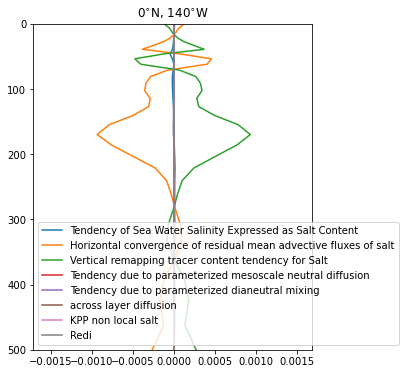

In [5]:
# figure with all components
fig, ax = plt.subplots(1, 1, figsize=(5,6))

ax.plot(ds_0N140W.osalttend.isel(time=3), ds_0N140W.zl, label='Tendency of Sea Water Salinity Expressed as Salt Content')
ax.plot(ds_0N140W.S_advection_xy.isel(time=3), ds_0N140W.zl, label='Horizontal convergence of residual mean advective fluxes of salt')
ax.plot(ds_0N140W.Sh_tendency_vert_remap.isel(time=3), ds_0N140W.zl, label='Vertical remapping tracer content tendency for Salt')
ax.plot(ds_0N140W.boundary_forcing_salt_tendency.isel(time=3), ds_0N140W.zl, label='Tendency due to parameterized mesoscale neutral diffusion')
ax.plot(ds_0N140W.osaltpmdiff.isel(time=3), ds_0N140W.zl, label='Tendency due to parameterized dianeutral mixing')
ax.plot(ds_0N140W.osaltdiff.isel(time=3), ds_0N140W.zl, label='across layer diffusion')
ax.plot(ds_0N140W.KPP_NLT_saln_budget.isel(time=3)*1e-3, ds_0N140W.zl, label='KPP non local salt')
ax.plot(ds_0N140W.S_lbdxy_cont_tendency.isel(time=3)*1e-3, ds_0N140W.zl, label='Redi')


ax.set_ylim(500,0)
ax.legend(loc='lower left')
ax.set_title(r'0$^{\circ}$N, 140$^{\circ}$W')
# plt.savefig('sb_0N140W_mom_zstar.png', bbox_inches='tight')

Text(0.5, 1.0, '0$^{\\circ}$N, 140$^{\\circ}$W')

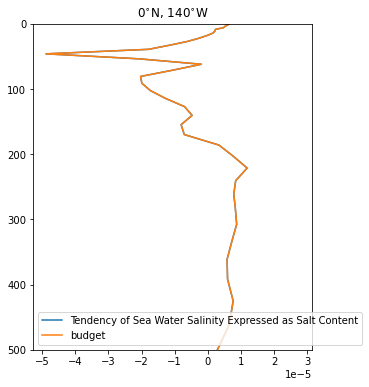

In [6]:
# figure with total tendency and sum of components 
fig, ax = plt.subplots(1, 1, figsize=(5,6))

ax.plot(ds_0N140W.osalttend.isel(time=3), ds_0N140W.zl, label='Tendency of Sea Water Salinity Expressed as Salt Content')


ax.plot((ds_0N140W.S_advection_xy + ds_0N140W.Sh_tendency_vert_remap + 
        ds_0N140W.boundary_forcing_salt_tendency + ds_0N140W.osaltpmdiff + 
       ds_0N140W.osaltdiff +  ds_0N140W.KPP_NLT_saln_budget*1e-3 +
        ds_0N140W.S_lbdxy_cont_tendency).isel(time=3), ds_0N140W.zl,
       label='budget')


ax.set_ylim(500,0)
ax.legend(loc='lower left')
ax.set_title(r'0$^{\circ}$N, 140$^{\circ}$W')
# plt.savefig('sb_0N140W_mom_zstar.png', bbox_inches='tight')

In [7]:
%%time
# test whether it closes all over 

xr.testing.assert_allclose(ds_hb.osalttend, 
                           (ds_hb.S_advection_xy+ds_hb.Sh_tendency_vert_remap+
                            ds_hb.boundary_forcing_salt_tendency+ds_hb.osaltpmdiff+
                            ds_hb.osaltdiff+ds_hb.KPP_NLT_saln_budget*1e-3+ds_hb.S_lbdxy_cont_tendency), 
                           rtol=1e-10)

CPU times: user 904 ms, sys: 73.5 ms, total: 977 ms
Wall time: 8.95 s
